# Исследование для М.Тех

Руководство компании обратило внимание на то, что сотрудники старше 35 лет болеют чаще, чем более молодые сотрудники. Кроме этого, среди мужчин количество пропусков рабочих дней в связи с больничным выше, чем среди женщин. В связи с этой ситуацией, руководство организации планирует ввести дополнительные медицинские осмотры среди групп риска.

Необходимо проверить следующие гипотезы:

1) Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин.

2) Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.

### 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from scipy import stats

### 2. Загрузка и предобработка данных

Датасет доступен по ссылке:
https://drive.google.com/file/d/1Yoes_MPH99GseTKf1lHPVeO0capkFbFW/view?usp=sharing

In [2]:
# Подгружаем данные
try:
  # путь к папке с файлами субтитров
  !gdown --id 1Yoes_MPH99GseTKf1lHPVeO0capkFbFW
  display('Данные загруженны корректно')
except:
  display('Данные не доступны')

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Yoes_MPH99GseTKf1lHPVeO0capkFbFW
To: /content/data.csv
100% 3.37k/3.37k [00:00<00:00, 9.07MB/s]


'Данные загруженны корректно'

In [3]:
# Чтение файла с подбором нужной кодировки
with open('/content/data.csv', 'rb') as file:
    result = chardet.detect(file.read())

df = pd.read_csv('/content/data.csv', encoding=result['encoding'],header=0, sep='\,', dtype='str')

<ipython-input-3-e41f64d93a2e>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/content/data.csv', encoding=result['encoding'],header=0, sep='\,', dtype='str')


In [4]:
# Получим первичную информацию о данных, проверим на наличие пропусков и дубликатов
def data_checkup(data):
    display(data.head(2))
    print()
    data.info()
    print()
    print('Количество явных дубликатов в датасете:', data.duplicated().sum())
    print()
    print('Столбцы с пропусками:')
    print()
    for column in data.columns:
        if data[column].isna().sum() > 0:
            print('Количество пропусков в столбце:', column,' - ', data[column].isna().sum(),
                  'Доля пропусков:', round((data[column].isna().sum()/len(data)),2))

In [5]:
data_checkup(df)

,"""Количество больничных дней","""""Возраст""""","""""Пол"""""""
0,"""5",39,"""""Ж"""""""
1,"""4",54,"""""М"""""""



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   "Количество больничных дней  237 non-null    object
 1   ""Возраст""                  237 non-null    object
 2   ""Пол"""                     237 non-null    object
dtypes: object(3)
memory usage: 5.7+ KB

Количество явных дубликатов в датасете: 72

Столбцы с пропусками:



In [6]:
# Очистим данные, удалим ненужные знаки

# Переведем названия столбцов и уберем лишние символы
#df.columns = ['Количество больничных дней',	'Возраст', 'Пол']
df.columns = ['work_days', 'age', 'sex']


# Обработка численных столбцов
num_cols = ['work_days', 'age']
for col in num_cols:
  # Заменить ненужные символы на пустую строку
  df[col] = df[col].replace('[^0-9\.]+', '', regex=True)
  # Заменить пустые строки на NaN
  df[col] = df[col].replace('', np.nan)
  # Привести к типу int
  df [col] = df[col].astype(int)


# Обработка столбца 'Пол'
# Заменить ненужные символы на пустую строку
df['sex'] = df['sex'].replace('[^А-Яа-я\,-,\.,\,]', '', regex=True)
# Заменить пустые строки на NaN
df['sex'] = df['sex'].replace('', np.nan)

In [7]:
# Уберем кириллицу из столбца 'sex'
df['sex'].replace({'М':'M', 'Ж':'F'}, inplace=True)

In [8]:
data_checkup(df)

,work_days,age,sex
0,5,39,F
1,4,54,M



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   work_days  237 non-null    int64 
 1   age        237 non-null    int64 
 2   sex        237 non-null    object
dtypes: int64(2), object(1)
memory usage: 5.7+ KB

Количество явных дубликатов в датасете: 72

Столбцы с пропусками:



Данные осмотрены и предобработаны. Попусков нет. Явные дубликаты трогать не будем, поскольку, учитывая скудный характер данных, это могут быть разные сотрудники с однаковыми характеристиками, а доля таких как бы дубликатов существенная.  

В результате предобработки данные были очищены от лишних символов.  

## 3. EDA

In [9]:
# Количество уникальных значений в столбце age
df['age'].nunique()

35

У нас 35 уникальных значений в признаке age, для анализа удобнее будет объединить сотрудников в группы по возрасту.

На основании возрастных диапазонов создим в датафрейме столбец age_group.

In [10]:
def age_group(age):
    try:
        if age < 30:
            return '< 30'
        elif 30 <= age <= 35:
            return '30-35'
        elif 36 <= age <= 40:
            return '36-40'
        elif 41 <= age <= 50:
            return '41-50'
        elif age >= 51:
            return '> 50'
    except:
        pass

In [11]:
df['age_group'] =  df['age'].apply(age_group)

In [12]:
# Сохраним предобработанный датасет для дашборда
df.to_csv('/content/data_prepared.csv', index=False)

In [13]:
# Всего пропущенных по болезни дней
df['work_days'].sum()

772

In [14]:
# Посмотрим на суммарные пропуски по возрастным группам с учетом пола сотрудников
df_pivot_age_group = df.pivot_table(index='age_group',
                                    columns='sex',
                                    values='work_days',
                                    aggfunc='sum').reset_index()

df_pivot_age_group['total_sum_work_days'] = df_pivot_age_group['M'] + df_pivot_age_group['F']
print('Количество пропущенных дней по возратным группам')
display(df_pivot_age_group)

Количество пропущенных дней по возратным группам


sex,age_group,F,M,total_sum_work_days
0,30-35,45,95,140
1,36-40,110,84,194
2,41-50,147,197,344
3,< 30,16,35,51
4,> 50,12,31,43


In [15]:
# Посмотрим количество сотрудников, пропустивших рабочие дни по болезни
df_pivot_age_group_2 = df.pivot_table(index='age_group',
                                    columns='sex',
                                    values='work_days',
                                    aggfunc='count').reset_index()

df_pivot_age_group_2['number_of_employees_in_age_group'] = df_pivot_age_group_2['F'] + df_pivot_age_group_2['M']
print('Количество сотрудников по возратным группам')
display(df_pivot_age_group_2)

Количество сотрудников по возратным группам


sex,age_group,F,M,number_of_employees_in_age_group
0,30-35,14,28,42
1,36-40,29,30,59
2,41-50,46,61,107
3,< 30,5,10,15
4,> 50,4,10,14


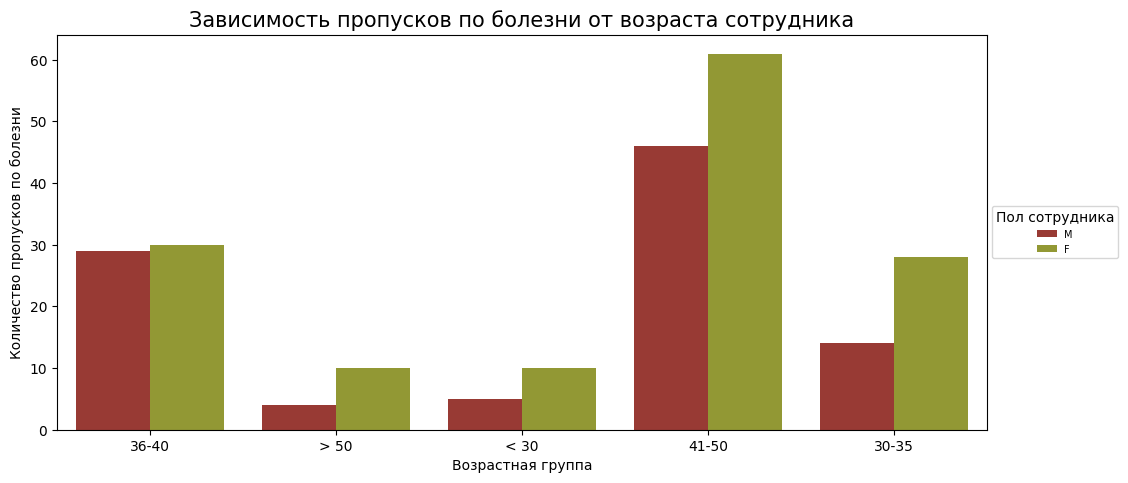

In [16]:
# График общей картины пропусков с учетом пола и возраста
plt.figure(figsize=(12,5))

plt.subplots_adjust(wspace=0.2, hspace=0.2, top=0.9)
plt.title('Зависимость пропусков по болезни от возраста сотрудника', fontsize=15)

sns.countplot(x='age_group', hue='sex', data=df, palette=sns.hls_palette(l=.4))
plt.legend(('M', 'F'), title='Пол сотрудника', fontsize=7, loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.xlabel('Возрастная группа', fontsize=10)
plt.ylabel('Количество пропусков по болезни', fontsize=10)

plt.show()

Судя по графику и сводным таблицам, больше всего болеют сотрудники в возрасте 41-50: суммарно на группу 344 пропущенных дня. Однако, это может связано с тем, что это самая многочисленная группа - 107 человек. Женщины в этой группе болеют чаще мужчин.

Вторая по количеству пропущенных дней группа - от 36 до 40лет: в ней на 59 человек суммарно 194 пропущенных дня. Женщины и мужчины в этой группе болеют примерно поровну.

Далее идет группа 30-35 лет: в ней на 42 сотрудника приходится 140 пропущенных по болезни дней. Женщины в этой группе болеют чаще.

Самые малочисленные группы - до 30(15 человек) и после 50 (14 человек) предсказуемо болеют реже остальных: на эти группы приходится 51 и 43 пропущенных дня соответственно.

На первый взгляд, предположение руководства компании о том, что сотрудники старше 35 лет болеют чаще, чем более молодые сотрудники, верное.

Однако, второе предположение, что среди мужчин количество пропусков рабочих дней в связи с больничным выше, чем среди женщин, кажется ошибочным.

Поэтому, проверим эти гипотезы статистическими методами.


## 4. Проверка статистических гипотез.

Необходимо проверить следующие гипотезы:

**1. Гипотеза: Мужчины пропускают в течение года более 2 рабочих дней по болезни значимо чаще женщин.**

`Нулевая гипотеза (H0)`: Мужчины и женщины пропускают в течение года одинаковое количество рабочих дней по болезни.

`Альтернативная гипотеза (H1`): Мужчины пропускают в течение года более 2 рабочих дней по болезни значимо чаще женщин.

Для проверки данной гипотезы можно воспользоваться двухвыборочным t-тестом независимых выборок, так как мы сравниваем две группы (мужчин и женщин).

In [17]:
# Делаем необходимые выборки данных
men = df[df['sex'] == 'M']['work_days']
women = df[df['sex'] == 'F']['work_days']

alpha = .05  # определяем уровень статистической значимости

# Проведение t-теста
t_statistic, p_value = stats.ttest_ind(men, women)
print('t-статистика:', t_statistic)
print('p-значение:', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

t-статистика: -0.7856303350416829
p-значение: 0.4328754720595044
Не получилось отвергнуть нулевую гипотезу


Проверим гипотезу №1 на более узкой выборке: отберем только тех сотрудников, которые пропустили по болезни более 2-х дней

In [18]:
# Отбираем всех, у кого более 2-х пропусков по болезни:
df_more_2 = df.query('work_days >2')

In [19]:
men_2 = df_more_2[df_more_2['sex'] == 'M']['work_days']
women_2 = df_more_2[df_more_2['sex'] == 'F']['work_days']

alpha = .05  # определяем уровень статистической значимости

# Проведение t-теста
t_statistic, p_value = stats.ttest_ind(men_2, women_2)
print('t-статистика:', t_statistic)
print('p-значение:', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

t-статистика: 0.41592499748510986
p-значение: 0.67806332103283
Не получилось отвергнуть нулевую гипотезу


**2. Гипотеза: Работники старше 35 лет пропускают в течение года более 2 рабочих дней по болезни значимо чаще своих более молодых коллег.**

`Нулевая гипотеза (H0)`: Работники старше 35 лет пропускают в течение года не более или равное количество рабочих дней по болезни, чем их более молодые коллеги.

`Альтернативная гипотеза (Н1)`: Работники старше 35 лет пропускают в течение года больше рабочих дней по болезни, чем их более молодые коллеги.

Для проверки этой гипотезы также можно воспользоваться статистическим тестом, например, двухвыборочным t-тестом для независимых выборок.

In [20]:
# Разделение данных на две выборки: работники старше 35 лет и работники младше 35 лет
older_employees = df[df['age'] > 35]['work_days']
younger_employees = df[df['age'] <= 35]['work_days']

alpha = .05  # определяем уровень статистической значимости

# Проведение t-теста
t_statistic, p_value = stats.ttest_ind(older_employees, younger_employees)
print('t-статистика:', t_statistic)
print('p-значение:', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

t-статистика: -0.447262667369775
p-значение: 0.6550973822138465
Не получилось отвергнуть нулевую гипотезу


Гипотезу №2 также проверим на более узкой выборке из  тех сотрудников, которые пропустили по болезни более 2-х дней

In [21]:
# ВАРИАНТ 2 - проверим гипотезы на выборках из сотрудников, пропустивших более 2-х дней по болезни

# Разделение данных на две выборки: работники старше 35 лет и работники младше 35 лет
older_employees_2 = df_more_2[df_more_2['age'] > 35]['work_days']
younger_employees_2 = df_more_2[df_more_2['age'] <= 35]['work_days']

alpha = .05  # определяем уровень статистической значимости

# Проведение t-теста
t_statistic, p_value = stats.ttest_ind(older_employees_2, younger_employees_2)
print('t-статистика:', t_statistic)
print('p-значение:', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


t-статистика: -0.7594348478395395
p-значение: 0.4487922957971878
Не получилось отвергнуть нулевую гипотезу


Построим графики распределения.

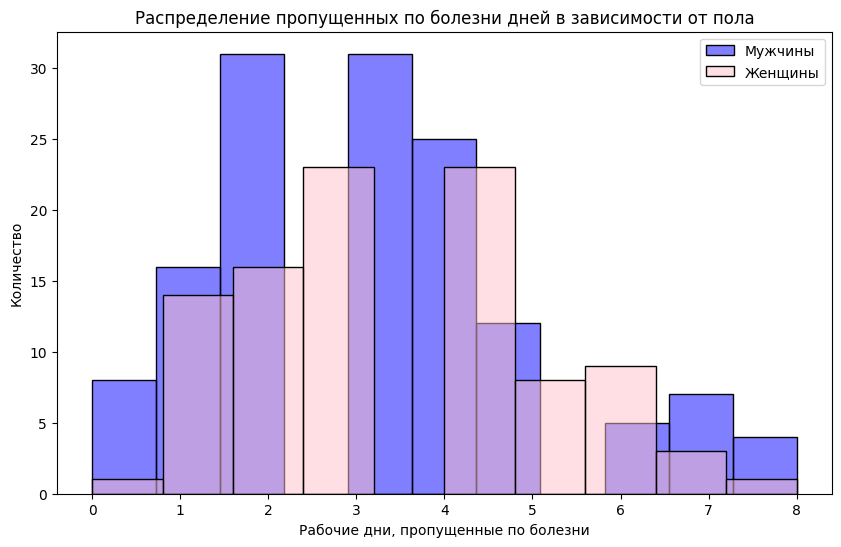

In [22]:
# Графики распределения пропусков рабочих дней по болезни для мужчин и женщин
plt.figure(figsize=(10, 6))
sns.histplot(men, color='blue', alpha=0.5, label='Мужчины')
sns.histplot(women, color='pink', alpha=0.5, label='Женщины')
plt.xlabel('Рабочие дни, пропущенные по болезни')
plt.ylabel('Количество')
plt.legend()
plt.title('Распределение пропущенных по болезни дней в зависимости от пола')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

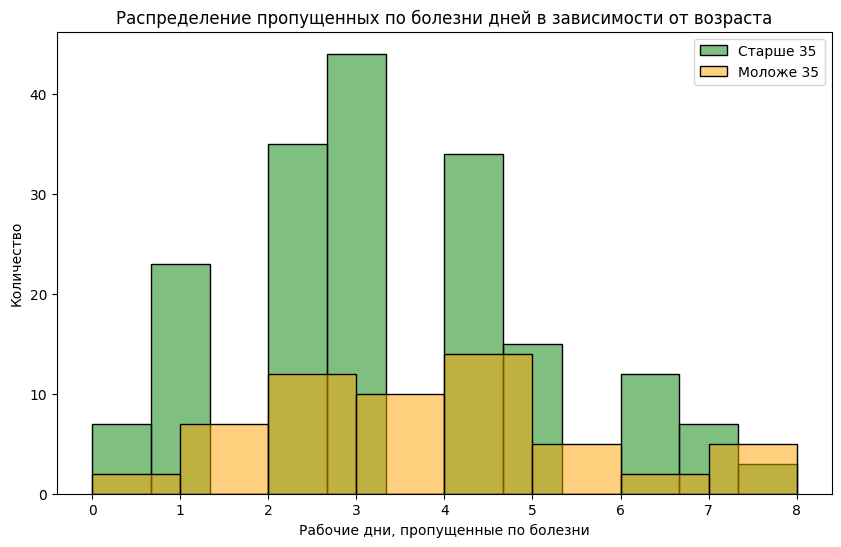

In [23]:
# Графики распределения пропусков рабочих дней по болезни для работников старше 35 лет и моложе 35 лет
plt.figure(figsize=(10, 6))
sns.histplot(older_employees, color='green', alpha=0.5, label='Старше 35')
sns.histplot(younger_employees, color='orange', alpha=0.5, label='Моложе 35')
plt.xlabel('Рабочие дни, пропущенные по болезни')
plt.ylabel('Количество')
plt.legend()
plt.title('Распределение пропущенных по болезни дней в зависимости от возраста')
plt.show

**ПРОВЕРКА СТАТИСТИЧЕСКИХ ГИПОТЕЗ. ВЫВОД**

**Для эксперимента №1:"Мужчины пропускают в течение года более 2 рабочих дней по болезни значимо чаще женщин"**

- была сформулирована следующая `нулевая гипотеза (H0):`

     Мужчины и женщины пропускают в течение года одинаковое количество рабочих дней по болезни.

**Для эксперимента №2:"Работники старше 35 лет пропускают в течение года более 2 рабочих дней по болезни значимо чаще своих более молодых коллег"**

- была сформулирована следующая `нулевая гипотеза (H0):`

     Работники старше 35 лет пропускают в течение года не более или равное количество рабочих дней по болезни, чем их более молодые коллеги.

Гипотезы проверялись на 2-х наборах данных:
1. полный набор
2. выборка из тех сотрудников, которые пропустили по болезни более 2-х дней

Таким образом, было проведено 4 статистических теста.

В всех 4-х случаях мы получили уровень статистической значимости p-value менее 0.05, что не позволяет отвергнуть нулевую гипотезу ни для одного из экспериментов.